**Importing libraries**

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D,\
                         GlobalAveragePooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers
from keras import callbacks
import random
import os
import matplotlib.pyplot as plt

print("Libraries imported")
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Libraries imported
Found GPU at: /device:GPU:0


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                         UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers
from keras import callbacks
print("Libraries imported")

Libraries imported


**Mounting drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the dataset**
I use the same split I obtained in the previous method

In [ ]:
datadir = '/content/drive/MyDrive/Data'
trainingset = datadir+'/train/'
valset = datadir + '/val/'
testset = datadir + '/test/'

batch_size=32
train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.1, rotation_range = 5,
                                   width_shift_range = 0.1, height_shift_range = 0.1,
                                   horizontal_flip = True, vertical_flip = False)

train_generator = train_datagen.flow_from_directory(directory = trainingset, target_size=(256, 256), color_mode='rgb',
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True)

val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_directory(directory = valset, target_size=(256, 256), color_mode="rgb",
                                                  batch_size=batch_size, class_mode="categorical", shuffle=False)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape
classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(val_generator.n,val_generator.num_classes))

Found 6007 images belonging to 8 classes.
Found 1726 images belonging to 8 classes.
Image input (256, 256, 3)
Classes: ['Breadsticks', 'Melons', 'Mop_Handles', 'Tea_drink_bottle', 'canned_tuna', 'dinnerware', 'grocery_bag', 'side_dish_plate']
Loaded 6007 training samples from 8 classes.
Loaded 1726 test samples from 8 classes.


**VGG16 Network**

In [ ]:
def load_vgg16_features(input_shape, init_weights=None):
    
    input0 = Input(shape=input_shape)
    vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights=init_weights, input_tensor=input0)
    feature_extractor = keras.models.Model(inputs=input0, outputs=vgg16_model.output, name="vgg16_features")
    optimizer = 'adam' 
    feature_extractor.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return feature_extractor

vgg16feat_model = load_vgg16_features(input_shape)
vgg16feat_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)    

**Transfer Learning with VGG16**

Weights initializated on ImageNet. I've chosen to train only the last convolutional layer of the last block of the network.

In [ ]:
def transferNet(input_shape, num_classes, output_layer_name, trainable_layers):
    
    feature_extractor = load_vgg16_features(input_shape, init_weights='imagenet')

    #INPUT
    input_t = feature_extractor.get_layer(index=0).input

   
    for idx,layer in enumerate(feature_extractor.layers):
      if layer.name in trainable_layers:
        layer.trainable = True
      else:
        layer.trainable = False

    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    #DL1
    dense1 = Dropout(0.5)(flatten_norm)
    dense1 = Dense(400, activation='relu')(dense1)
    dense1 = BatchNormalization()(dense1)
    
    #DL2
    dense2 = Dropout(0.5)(dense1)
    dense2 = Dense(100, activation='relu')(dense2)
    dense2 = BatchNormalization()(dense2)

    #Output
    dense3 = BatchNormalization()(dense2)
    dense3 = Dense(num_classes, activation='softmax')(dense3)
    
    model = keras.models.Model(inputs=input_t, outputs=dense3, name="transferNet")
    
    optimizer = 'adam'
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model



name_output_extractor = "block5_pool"
trainable_layers = ["block5_conv3"]


transfer_model = transferNet(input_shape, num_classes, name_output_extractor, trainable_layers)
transfer_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "transferNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
________________________________________________________

**We train the model**

In [ ]:
epochs = 10

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = val_generator.n//val_generator.batch_size+1

try:
    transfer_history = transfer_model.fit(train_generator, epochs=epochs, verbose=1,
                    steps_per_epoch=steps_per_epoch, validation_data=val_generator, validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/10
187/187 [==============================] - 2232s 12s/step - loss: 1.0958 - accuracy: 0.6298 - val_loss: 0.8685 - val_accuracy: 0.7375
Epoch 2/10
187/187 [==============================] - 107s 571ms/step - loss: 0.7564 - accuracy: 0.7485 - val_loss: 0.7292 - val_accuracy: 0.7758
Epoch 3/10
187/187 [==============================] - 106s 565ms/step - loss: 0.6532 - accuracy: 0.7756 - val_loss: 0.6519 - val_accuracy: 0.7793
Epoch 4/10
187/187 [==============================] - 105s 563ms/step - loss: 0.5862 - accuracy: 0.8033 - val_loss: 0.6468 - val_accuracy: 0.7879
Epoch 5/10
187/187 [==============================] - 105s 562ms/step - loss: 0.5401 - accuracy: 0.8172 - val_loss: 0.6319 - val_accuracy: 0.7955
Epoch 6/10
187/187 [==============================] - 104s 559ms/step - loss: 0.4892 - accuracy: 0.8308 - val_loss: 0.6264 - val_accuracy: 0.7943
Epoch 7/10
187/187 [==============================] - 104s 558ms/step - loss: 0.4567 - accuracy: 0.8428 - val_loss: 0.6330 - 

**Accuracy and loss over training epochs**

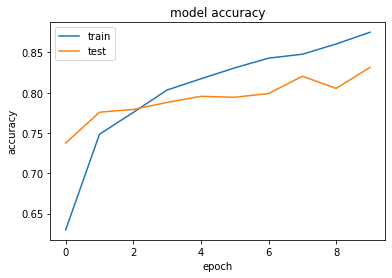

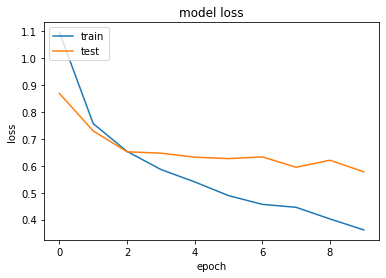

In [ ]:
# summarize history for accuracy
plt.plot(transfer_history.history['accuracy'])
plt.plot(transfer_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(transfer_history.history['loss'])
plt.plot(transfer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Saving the model**

In [ ]:
models_dir = datadir

def savemodel(model, problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

savemodel(transfer_model,'My_Transfer_Learning_model')


Model saved successfully on file /content/drive/MyDrive/Data/My_Transfer_Learning_model.h5



**Loading the presaved model**
Not necessary in this case, but it's always good to have a loading function

In [ ]:
from keras.models import load_model

models_dir = datadir

def loadmodel(problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:    
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    return model

transfer_model = loadmodel('My_Transfer_Learning_model')

**Now, we evaluate the model**

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = transfer_model.evaluate(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

Found 855 images belonging to 8 classes.
27/27 [==============================] - 283s 10s/step - loss: 0.6275 - accuracy: 0.8070
Test loss: 0.627492
Test accuracy: 0.807018


In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

preds = transfer_model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

27/27 [==============================] - 4s 155ms/step
                  precision    recall  f1-score   support

     Breadsticks      0.832     0.808     0.820       104
          Melons      0.835     0.812     0.824       112
     Mop_Handles      0.917     0.885     0.901       113
Tea_drink_bottle      0.888     0.879     0.883        99
     canned_tuna      0.852     0.726     0.784        95
      dinnerware      0.784     0.726     0.754        95
     grocery_bag      0.769     0.945     0.848       109
 side_dish_plate      0.644     0.680     0.662       128

        accuracy                          0.807       855
       macro avg      0.815     0.808     0.809       855
    weighted avg      0.811     0.807     0.807       855



**A function for Confusion Matrix**

In [ ]:
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

**Confusion Matrix**

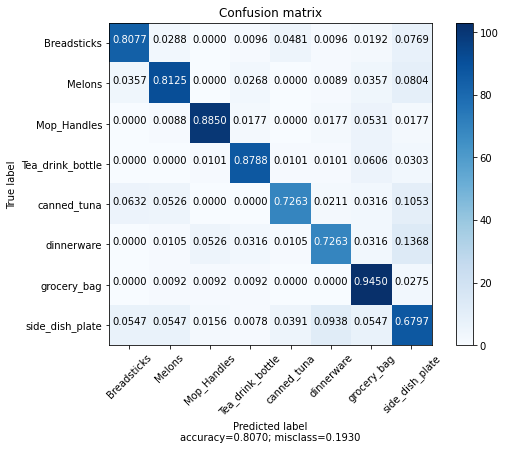

In [ ]:
cm = confusion_matrix(Ytest, Ypred, labels=None, sample_weight=None)
plot_confusion_matrix(cm, classnames)